In [258]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

#from pylab import rcParams
#rcParams['figure.figsize'] = 10,7

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [259]:
df=pd.read_csv("/content/parsa_load.csv")

In [260]:
print("The shape of dataset is ", df.shape)

The shape of dataset is  (2989, 3)


In [261]:
# Now, Define column names, drop nulls, convert Date to DateTime format and make Date as an index column because it is not possible to plot the graph without index.

In [262]:
df.columns

Index(['epoch', 'time', 'parsa_load_total_active_power'], dtype='object')

In [263]:
df.head()

,epoch,time,parsa_load_total_active_power
0,1583001000,01-03-2020 00:00,713.933333
1,1583004600,01-03-2020 01:00,699.683333
2,1583008200,01-03-2020 02:00,679.366667
3,1583011800,01-03-2020 03:00,658.366667
4,1583015400,01-03-2020 04:00,636.533333


In [264]:
df=df.drop("epoch", 1)

In [265]:
df.columns=['Date', 'Power']

In [266]:
df.head()

,Date,Power
0,01-03-2020 00:00,713.933333
1,01-03-2020 01:00,699.683333
2,01-03-2020 02:00,679.366667
3,01-03-2020 03:00,658.366667
4,01-03-2020 04:00,636.533333


In [267]:
df.isnull().sum()

Date       0
Power    180
dtype: int64

In [268]:
df=df.dropna()

In [269]:
df.isnull().sum()

Date     0
Power    0
dtype: int64

In [271]:
# As we can see , an observation is recorded every 1 hour. This means that, for a single day, we will have 24 observations. 

In [273]:
# Now we want to predict the power for 24 hours in the future.
# In order to make this prediction, we choose to use 95 days of observations.
# Thus, you would create a window containing the last 2280(95x24) observations to train the model.

In [274]:
# The function below returns the above described windows of time for the model to train on. 
# The parameter history_size is the size of the past window of information.
# The target_size is how far in the future does the model need to learn to predict. 
# The target_size is the label that needs to be predicted.

In [275]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)

    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [276]:
df.shape

(2809, 2)

In [277]:
# I am taking 95 days for training data i.e. (95*24= ) observations

TRAIN_SPLIT = 2280

In [278]:
#Setting seed to ensure reproducibility.
tf.random.set_seed(13)

In [279]:
#  Forecast a univariate time series

In [280]:
df.head()

,Date,Power
0,01-03-2020 00:00,713.933333
1,01-03-2020 01:00,699.683333
2,01-03-2020 02:00,679.366667
3,01-03-2020 03:00,658.366667
4,01-03-2020 04:00,636.533333


In [281]:
uni_data = df['Power']
uni_data.index = df['Date']
uni_data.head()

Date
01-03-2020 00:00    713.933333
01-03-2020 01:00    699.683333
01-03-2020 02:00    679.366667
01-03-2020 03:00    658.366667
01-03-2020 04:00    636.533333
Name: Power, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fccd331f160>],
      dtype=object)

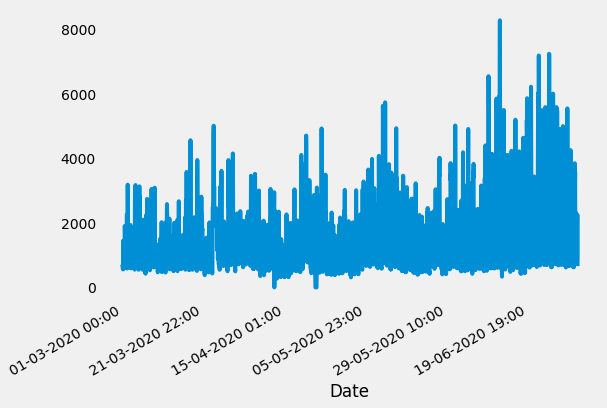

In [282]:
# Let's observe how this data looks across time.

uni_data.plot(subplots=True)

In [283]:
uni_data = uni_data.values

In [284]:
# It is important to scale features before training a neural network. 
# Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.
# we can also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].

In [285]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [286]:
# Let's standardize the data.

uni_data = (uni_data-uni_train_mean)/uni_train_std

In [296]:
# Let's now create the data for the univariate model.
# Now the model will be given the last 120 recorded power observations, and needs to learn to predict the power at the next time step.

In [289]:
univariate_past_history = 120
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [290]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target power to predict')
print (y_train_uni[0])

Single window of past history
[[-0.64331561]
 [-0.66114411]
 [-0.68656276]
 [-0.71283634]
 [-0.74015253]
 [-0.82791881]
 [-0.84015897]
 [-0.20016783]
 [ 0.28199414]
 [-0.80556541]
 [-0.77822837]
 [-0.64986315]
 [-0.49791426]
 [-0.6142687 ]
 [-0.6762827 ]
 [-0.28766303]
 [-0.22942325]
 [ 0.84981254]
 [ 0.53407458]
 [-0.07021785]
 [ 0.55718206]
 [-0.64896651]
 [-0.68232979]
 [-0.63958309]
 [-0.65588939]
 [-0.64143892]
 [-0.68247576]
 [-0.68554101]
 [-0.64692301]
 [-0.78804969]
 [ 1.30248869]
 [-0.80310785]
 [ 0.43275447]
 [ 0.8931886 ]
 [ 0.68131091]
 [ 2.45231728]
 [ 1.05470859]
 [-0.42242983]
 [-0.47328799]
 [-0.55102443]
 [-0.25648921]
 [ 0.29569394]
 [-0.18152609]
 [-0.45497988]
 [-0.59316642]
 [-0.66977686]
 [-0.69834417]
 [-0.72180273]
 [-0.70107579]
 [-0.71569307]
 [-0.66769165]
 [-0.76565459]
 [ 0.88795474]
 [-0.66020577]
 [-0.73539826]
 [-0.79824634]
 [-0.70434956]
 [-0.65107257]
 [-0.3874818 ]
 [-0.25919998]
 [-0.29927762]
 [ 0.18820162]
 [-0.07121874]
 [-0.28657872]
 [-0.21985

In [291]:
# Now that the data has been created, let's take a look at a single example. 
# The information given to the network is given in blue, and it must predict the value at the red cross.

In [292]:
def create_time_steps(length):
   return list(range(-length, 0))

In [293]:
def show_plot(plot_data, delta, title):
   labels = ['History', 'True Future', 'Model Prediction']
   marker = ['.-', 'rx', 'go']
   time_steps = create_time_steps(plot_data[0].shape[0])
   if delta:
     future = delta
   else:
     future = 0

   plt.title(title)
   for i, x in enumerate(plot_data):
     if i:
       plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
     else:
       plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
   plt.legend()
   plt.xlim([time_steps[0], (future+5)*2])
   plt.xlabel('Time-Step')
   return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

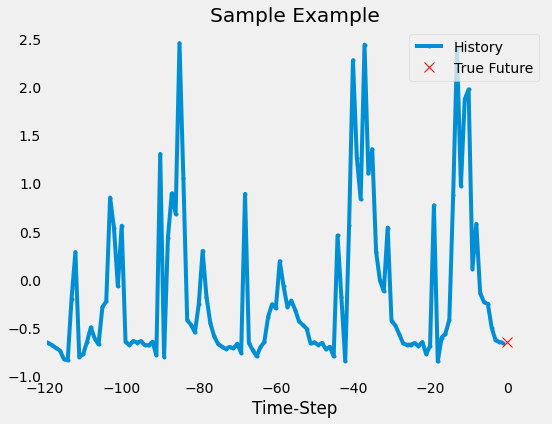

In [294]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [297]:
# Baseline
# Before proceeding to train a model, let's first set a simple baseline. 
# Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 120 observations.

In [298]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

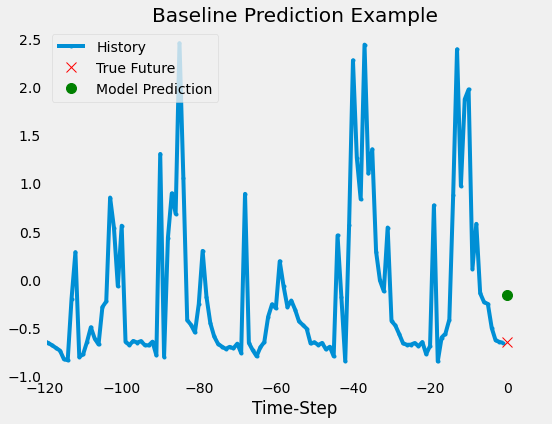

In [299]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [300]:
# As we can see this baseline approach didnt work weel in predictions

In [301]:
# Let's see RNN now if it  can beat this baseline.
# A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.

In [302]:
# Let's now use tf.data to shuffle, batch, and cache the dataset.

BATCH_SIZE = 24
BUFFER_SIZE = 200

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [303]:
# You will see the LSTM requires the input shape of the data it is being given.

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [304]:
# Let's make a sample prediction, to check the output of the model.

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(24, 1)


In [306]:
# Let's train the model now. 

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=5)

Epoch 1/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4592 - val_loss: 0.6653
Epoch 2/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4576 - val_loss: 0.6551
Epoch 3/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4585 - val_loss: 0.6431
Epoch 4/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4641 - val_loss: 0.6401
Epoch 5/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4577 - val_loss: 0.6370
Epoch 6/10
200/200 [==============================] - 7s 36ms/step - loss: 0.4501 - val_loss: 0.6402
Epoch 7/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4516 - val_loss: 0.6368
Epoch 8/10
200/200 [==============================] - 7s 33ms/step - loss: 0.4561 - val_loss: 0.6343
Epoch 9/10
200/200 [==============================] - 7s 33ms/step - loss: 0.4626 - val_loss: 0.6333
Epoch 10/10
200/200 [==============================] - 7s 33ms/step - loss: 0.4470 - val_lo

In [307]:
# Predict using the simple LSTM model
# Now that we have trained our simple LSTM, let's try and make a few predictions.

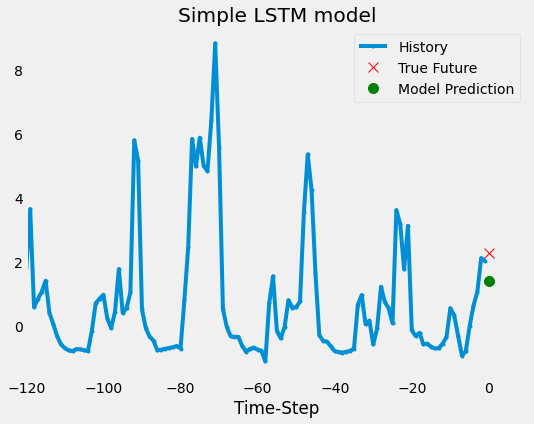

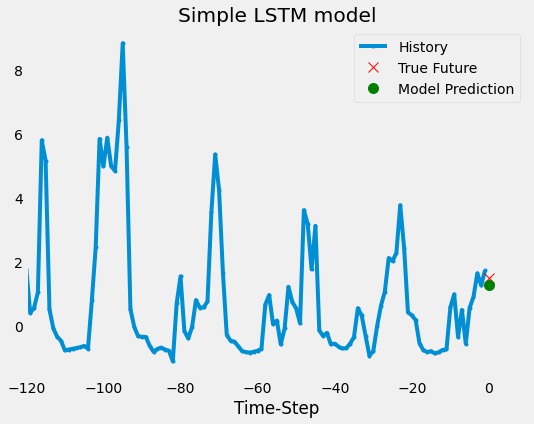

In [310]:
for x, y in val_univariate.take(2):
 plot = show_plot([x[0].numpy(), y[0].numpy(),
                   simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
 plot.show()

In [311]:
# This looks much better than the baseline.

In [314]:
# Lets print predictions for next 24 hours
output=[]
for i in range(0,24):
   o=(simple_lstm_model.predict(x)[i], i)
   output.append(o)
   i+=1

In [315]:
output

[(array([1.2740295], dtype=float32), 0),
 (array([1.113847], dtype=float32), 1),
 (array([1.651821], dtype=float32), 2),
 (array([1.1538267], dtype=float32), 3),
 (array([1.1347959], dtype=float32), 4),
 (array([0.08536834], dtype=float32), 5),
 (array([-0.11372597], dtype=float32), 6),
 (array([-0.4504072], dtype=float32), 7),
 (array([-0.6435559], dtype=float32), 8),
 (array([-0.6957151], dtype=float32), 9),
 (array([-0.7391396], dtype=float32), 10),
 (array([-0.77830684], dtype=float32), 11),
 (array([-0.7447468], dtype=float32), 12),
 (array([-0.7328633], dtype=float32), 13),
 (array([-0.6834036], dtype=float32), 14),
 (array([0.4413196], dtype=float32), 15),
 (array([0.583458], dtype=float32), 16),
 (array([-0.18462837], dtype=float32), 17),
 (array([0.27567944], dtype=float32), 18),
 (array([0.49809036], dtype=float32), 19),
 (array([0.04937701], dtype=float32), 20),
 (array([1.121098], dtype=float32), 21),
 (array([1.2481713], dtype=float32), 22),
 (array([0.6403888], dtype=floa

In [317]:
df.tail()

,Date,Power
2979,03-07-2020 03:00,780.366667
2980,03-07-2020 04:00,884.450000
2981,03-07-2020 05:00,2226.500000
2982,03-07-2020 06:00,2252.939394
2983,03-07-2020 07:00,660.000000


In [318]:
df2 =pd.DataFrame (output,columns=['Predicted_Power', 'Hours'])

In [319]:
df2.tail()

,Predicted_Power,Hours
19,[0.49809036],19
20,[0.049377006],20
21,[1.121098],21
22,[1.2481713],22
23,[0.6403888],23


In [320]:
df2.dtypes

Predicted_Power    object
Hours               int64
dtype: object

In [321]:
df2["Predicted_Power"] = df2["Predicted_Power"].astype(float)

In [322]:
df2.head()

,Predicted_Power,Hours
0,1.274029,0
1,1.113847,1
2,1.651821,2
3,1.153827,3
4,1.134796,4


In [323]:
df2.dtypes

Predicted_Power    float64
Hours                int64
dtype: object

In [326]:
pred_data = df2['Predicted_Power']
pred_data.index = df2['Hours']
pred_data

Hours
0     1.274029
1     1.113847
2     1.651821
3     1.153827
4     1.134796
5     0.085368
6    -0.113726
7    -0.450407
8    -0.643556
9    -0.695715
10   -0.739140
11   -0.778307
12   -0.744747
13   -0.732863
14   -0.683404
15    0.441320
16    0.583458
17   -0.184628
18    0.275679
19    0.498090
20    0.049377
21    1.121098
22    1.248171
23    0.640389
Name: Predicted_Power, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fccd37dc198>],
      dtype=object)

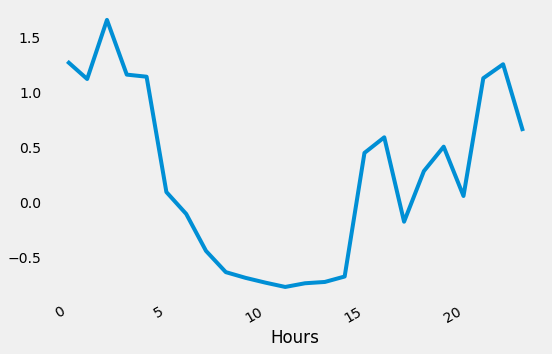

In [325]:
# Let's observe how this predicted data looks across time.

pred_data.plot(subplots=True)

In [ ]:
# These predictions are for next 24 hours after given data
# Data is given at last 3-july-2020, 7hrs
# Predictions are accordingly for next 24 hours i.e. 3-july-2020, 8hrs, to 4-july-2020, 7hrs